This Notebook constains code that runs statistical test to see whether the ensemble types differ after controlling for correlations.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
import re

from knobs_functions import *

In [2]:
def correlation_table(state, chamber, my_ensemble_list=ensemble_list, my_score_list=primary_score_list, 
                      step_size=1, rounding=None, return_dataframe=False):
    '''
    Returns a correlation table for the scores in my_score_list over the ensembles in my_ensemble_list.
    Set step_size to 1 to use all the plans, or a larger number to subsample the data (to use less memory).
    Optionally returns the dataframe used to create the correlation table.
    '''
    all_rows = []

    for ensemble in my_ensemble_list:
        score_arrays = {
            score: fetch_score_array(state, chamber, ensemble, score)[::step_size]
            for score in my_score_list
        }
        num_plans = len(next(iter(score_arrays.values())))
        for i in range(num_plans):
            row = [score_arrays[score][i] for score in my_score_list] + [ensemble]
            all_rows.append(row)

    df = pd.DataFrame(all_rows, columns=my_score_list + ['ensemble'])

    corr = df.corr(numeric_only=True)
    if rounding is not None:
        corr = corr.round(rounding)

    return (corr, df) if return_dataframe else corr

In [8]:
my_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median', 'partisan bias',
                  'competitive districts', 'average margin', 'county splits']
print(my_score_list)

['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin', 'county splits']


In [9]:
# Let's find the correlation table for all state-chamber combinations

D = dict() # dictionary mapping (state, chamber) to the correlation table using all ensembles    
#D0 = dict() # dictionary mapping (state, chamber) to the correlation table for only the base0 ensemble

for state, chamber in state_chamber_list:
    print(state, chamber)
    D[(state, chamber)] = correlation_table(state, chamber, my_score_list=my_score_list)
    #D0[(state, chamber)] = correlation_table(state, chamber, my_score_list=my_score_list, my_ensemble_list=['base0'])

FL congress
FL upper
FL lower
IL congress
IL upper
IL lower
MI congress
MI upper
MI lower
NC congress
NC upper
NC lower
NY congress
NY upper
NY lower
OH congress
OH upper
OH lower
WI congress
WI upper
WI lower


In [15]:
# Let's average the correlation tables over the state-chamber combinations

avg_corr = pd.DataFrame(0, columns = my_score_list, index = my_score_list)
#avg_corr0 = pd.DataFrame(0, columns = my_score_list, index = my_score_list) # just using the base0 ensemble
for state_chamber in state_chamber_list:
    avg_corr += D[state_chamber]
    #avg_corr0 += D0[state_chamber]
avg_corr /= len(state_chamber_list)
#avg_corr0 /= len(state_chamber_list)
avg_corr.round(2)

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,county splits
Reock,1.00,0.73,-0.73,0.01,-0.01,0.03,-0.01,-0.03,0.26,-0.63
Polsby-Popper,0.73,1.00,-0.91,-0.00,-0.00,0.05,-0.01,-0.04,0.33,-0.95
cut edges,-0.73,-0.91,1.00,0.00,0.00,-0.04,0.00,0.04,-0.34,0.81
Dem seats,0.01,-0.00,0.00,1.00,-0.99,-0.24,-0.62,0.01,-0.09,0.00
efficiency gap,-0.01,-0.00,0.00,-0.99,1.00,0.24,0.61,-0.02,0.11,0.01
mean-median,0.03,0.05,-0.04,-0.24,0.24,1.00,0.37,-0.18,0.21,-0.04
partisan bias,-0.01,-0.01,0.00,-0.62,0.61,0.37,1.00,-0.03,0.14,0.02
competitive districts,-0.03,-0.04,0.04,0.01,-0.02,-0.18,-0.03,1.00,-0.52,0.04
average margin,0.26,0.33,-0.34,-0.09,0.11,0.21,0.14,-0.52,1.00,-0.32
county splits,-0.63,-0.95,0.81,0.00,0.01,-0.04,0.02,0.04,-0.32,1.00


In [22]:
# Let's mark with * the score pairs for which the sign of the correlation is consistent across all state-chamber combinations.
avg_corr_marked = avg_corr.copy().round(2)
for score1 in my_score_list:
    for score2 in my_score_list:
        num_pos = len([1 for state_chamber in state_chamber_list if D[state_chamber].loc[score1, score2] > 0])
        consistent_sign = 1 if num_pos == len(state_chamber_list) else -1 if num_pos == 0 else 0
        if consistent_sign !=0:
            avg_corr_marked.loc[score1, score2] = f'*{avg_corr_marked.loc[score1, score2]}'
avg_corr_marked.to_excel('tables/avg_corr.xlsx')
avg_corr_marked

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,county splits
Reock,*1.0,*0.73,*-0.73,0.01,-0.01,0.03,-0.01,-0.03,0.26,*-0.63
Polsby-Popper,*0.73,*1.0,*-0.91,-0.0,-0.0,0.05,-0.01,-0.04,*0.33,*-0.95
cut edges,*-0.73,*-0.91,*1.0,0.0,0.0,-0.04,0.0,0.04,*-0.34,*0.81
Dem seats,0.01,-0.0,0.0,*1.0,*-0.99,-0.24,*-0.62,0.01,-0.09,0.0
efficiency gap,-0.01,-0.0,0.0,*-0.99,*1.0,0.24,*0.61,-0.02,0.11,0.01
mean-median,0.03,0.05,-0.04,-0.24,0.24,*1.0,0.37,-0.18,0.21,-0.04
partisan bias,-0.01,-0.01,0.0,*-0.62,*0.61,0.37,*1.0,-0.03,0.14,0.02
competitive districts,-0.03,-0.04,0.04,0.01,-0.02,-0.18,-0.03,*1.0,*-0.52,0.04
average margin,0.26,*0.33,*-0.34,-0.09,0.11,0.21,0.14,*-0.52,*1.0,*-0.32
county splits,*-0.63,*-0.95,*0.81,0.0,0.01,-0.04,0.02,0.04,*-0.32,*1.0


In [23]:
# Process and output table for LaTex
def stack_string(a):
    l = re.split(r"[ -]+", a)
    if len(l) == 1:
        return l[0]
    else:
        return f'\\makecell{{{l[0]} \\\\ {l[1]}}}'
    
col_dict = {score: stack_string(score) for score in my_score_list}

avg_corr_marked.rename(columns=col_dict, inplace=True)
avg_corr_marked.to_latex('latex tables/correlations.tex', escape=False)

C:\Users\ktapp\AppData\Local\Temp\ipykernel_39300\1145035282.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  avg_corr_marked.to_latex('latex tables/correlations.tex', escape=False)


In [13]:
# Let's make a table showing the range of values over the state-chamber combinations
range_corr = pd.DataFrame(0, columns = my_score_list, index = my_score_list)
for score1 in my_score_list:
    for score2 in my_score_list:
        min_corr = min([D[state_chamber].loc[score1, score2] for state_chamber in state_chamber_list])
        max_corr = max([D[state_chamber].loc[score1, score2] for state_chamber in state_chamber_list])
        range_corr.loc[score1, score2] = f'({min_corr:.2f},{max_corr:.2f})'
range_corr.to_excel('tables/range_corr.xlsx')
range_corr

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,county splits
Reock,"(1.00,1.00)","(0.39,0.87)","(-0.88,-0.29)","(-0.13,0.26)","(-0.27,0.13)","(-0.16,0.25)","(-0.21,0.20)","(-0.37,0.19)","(-0.04,0.60)","(-0.80,-0.24)"
Polsby-Popper,"(0.39,0.87)","(1.00,1.00)","(-0.95,-0.87)","(-0.23,0.33)","(-0.35,0.24)","(-0.20,0.31)","(-0.25,0.29)","(-0.44,0.22)","(0.04,0.69)","(-0.98,-0.92)"
cut edges,"(-0.88,-0.29)","(-0.95,-0.87)","(1.00,1.00)","(-0.36,0.26)","(-0.27,0.37)","(-0.27,0.19)","(-0.33,0.27)","(-0.23,0.39)","(-0.63,-0.06)","(0.77,0.88)"
Dem seats,"(-0.13,0.26)","(-0.23,0.33)","(-0.36,0.26)","(1.00,1.00)","(-1.00,-0.97)","(-0.71,0.22)","(-0.84,-0.33)","(-0.15,0.30)","(-0.41,0.22)","(-0.34,0.23)"
efficiency gap,"(-0.27,0.13)","(-0.35,0.24)","(-0.27,0.37)","(-1.00,-0.97)","(1.00,1.00)","(-0.22,0.71)","(0.33,0.84)","(-0.30,0.16)","(-0.23,0.41)","(-0.24,0.36)"
mean-median,"(-0.16,0.25)","(-0.20,0.31)","(-0.27,0.19)","(-0.71,0.22)","(-0.22,0.71)","(1.00,1.00)","(-0.41,0.85)","(-0.69,0.52)","(-0.30,0.64)","(-0.31,0.20)"
partisan bias,"(-0.21,0.20)","(-0.25,0.29)","(-0.33,0.27)","(-0.84,-0.33)","(0.33,0.84)","(-0.41,0.85)","(1.00,1.00)","(-0.48,0.35)","(-0.34,0.59)","(-0.30,0.25)"
competitive districts,"(-0.37,0.19)","(-0.44,0.22)","(-0.23,0.39)","(-0.15,0.30)","(-0.30,0.16)","(-0.69,0.52)","(-0.48,0.35)","(1.00,1.00)","(-0.68,-0.30)","(-0.23,0.45)"
average margin,"(-0.04,0.60)","(0.04,0.69)","(-0.63,-0.06)","(-0.41,0.22)","(-0.23,0.41)","(-0.30,0.64)","(-0.34,0.59)","(-0.68,-0.30)","(1.00,1.00)","(-0.69,-0.04)"
county splits,"(-0.80,-0.24)","(-0.98,-0.92)","(0.77,0.88)","(-0.34,0.23)","(-0.24,0.36)","(-0.31,0.20)","(-0.30,0.25)","(-0.23,0.45)","(-0.69,-0.04)","(1.00,1.00)"


In [ ]:
# Let's plot the correlation between 'cut edges' and 'county splits' for FL Congress
# with a reduced set of ensembles for simplicity
short_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county100']
corr, df = correlation_table('FL', 'lower', my_ensemble_list=short_ensemble_list, 
                             my_score_list = ['cut edges', 'county splits', 'Polsby-Popper'], step_size=1, return_dataframe=True)

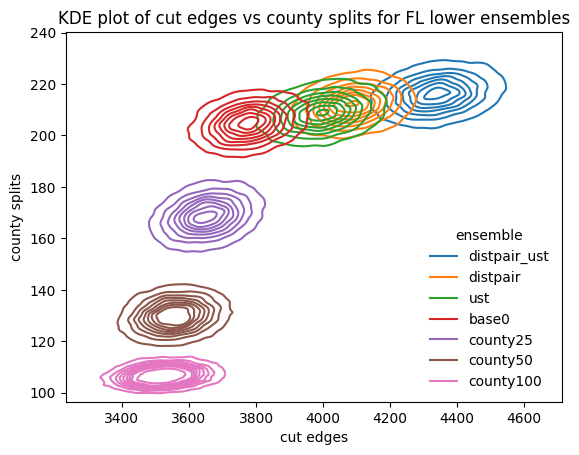

In [27]:
ax = sns.kdeplot(df, x='cut edges', y='county splits', hue='ensemble')
plt.title('KDE plot of cut edges vs county splits for FL lower ensembles')
ax.legend_.set_loc('lower right')  # Move the existing legend
ax.legend_.get_frame().set_linewidth(0)  # Remove the box around the legend
plt.savefig('graphs/kde_FL.png')
plt.show()

In [ ]:
# let's generate such a plot for all state-chamber combinations
for state, chamber in state_chamber_list:
    print(state, chamber)
    corr, df = correlation_table(state, chamber, my_ensemble_list=short_ensemble_list, 
                                 my_score_list=['cut edges', 'county splits'], step_size=1, return_dataframe=True)
    ax = sns.kdeplot(df, x='cut edges', y='county splits', hue='ensemble')
    plt.title(f'{state} {chamber}: KDE plot of cut edges vs county splits')
    ax.legend_.set_loc('lower right')  # Move the existing legend
    ax.legend_.get_frame().set_linewidth(0)  # Remove the box around the legend
    plt.savefig(f'graphs/kdeplot_cut_edges_vs_county_splits_{state}_{chamber}.png')
    plt.show()

In [ ]:
# Let's zoom back out to the larger set of ensembles and scores
corr, df = correlation_table('FL', 'congress', my_ensemble_list=my_ensemble_list, my_score_list = my_score_list, step_size=1, return_dataframe=True)

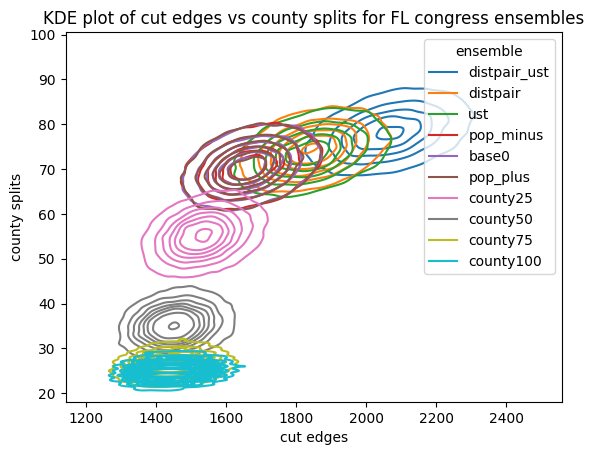

In [ ]:
# Repeat the above plot with the full set of ensembles
sns.kdeplot(df, x='cut edges', y='county splits', hue='ensemble')
plt.title('KDE plot of cut edges vs county splits for FL congress ensembles')
plt.savefig('graphs/kdeplot_cut_edges_vs_county_splits.png')
plt.show()

In [38]:
# Now let's run ANCOVA

# first convert all measurements to standard units, so that the regression coefficients are comparable
df_std = df.copy()
scaler = StandardScaler()
df_std[["average margin", "Polsby-Popper", "county splits"]] = scaler.fit_transform(
    df[["average margin", "Polsby-Popper", "county splits"]]
)

# Now find the regression coefficients
model_std = ols('Q("average margin") ~ Q("Polsby-Popper") + Q("county splits") + C(ensemble)', data=df_std).fit()
print(model_std.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("average margin")   R-squared:                       0.192
Model:                             OLS   Adj. R-squared:                  0.192
Method:                  Least Squares   F-statistic:                     4326.
Date:                 Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                         12:29:54   Log-Likelihood:            -2.6244e+05
No. Observations:               200000   AIC:                         5.249e+05
Df Residuals:                   199988   BIC:                         5.250e+05
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

In [44]:
ancova_table = anova_lm(model_std, typ=2)
print(ancova_table)

                           sum_sq        df           F         PR(>F)
C(ensemble)           5894.710767       9.0  810.759575   0.000000e+00
Q("Polsby-Popper")     128.433261       1.0  158.982604   1.949074e-36
Q("county splits")     773.015896       1.0  956.886703  1.325266e-209
Residual            161559.255088  199988.0         NaN            NaN


In [ ]:
# Create dataframe showing ANOVA results for all state-chamber combinations

Regression_dict = dict() # dictionary mapping (state, chamber) to the regression coefficients using all ensembles
ANCOVA_dict = dict() # dictionary mapping (state, chamber) to the ANCOVA table using all ensembles

for state, chamber in state_chamber_list:
    print(state, chamber)
    corr, df = correlation_table(state, chamber, my_ensemble_list=my_ensemble_list, my_score_list = my_score_list, step_size=1, return_dataframe=True)
    # first convert all measurements to standard units, so that the regression coefficients are comparable
    df_std = df.copy()
    scaler = StandardScaler()
    df_std[["average margin", "Polsby-Popper", "county splits"]] = scaler.fit_transform(
        df[["average margin", "Polsby-Popper", "county splits"]]
    )
    model_std = ols('Q("average margin") ~ Q("Polsby-Popper") + Q("county splits") + C(ensemble)', data=df_std).fit()
    Regression_dict[f'{state}_{chamber}'] = model_std.params
    ANCOVA_dict[f'{state}_{chamber}'] = anova_lm(model_std, typ=2)['sum_sq']

In [59]:
ANCOVA_df = pd.DataFrame(ANCOVA_dict).T
ANCOVA_df.loc["average"] = ANCOVA_df.mean(numeric_only=True) # add average row
ANCOVA_df

,C(ensemble),"Q(""Polsby-Popper"")","Q(""county splits"")",Residual
FL_congress,5894.710767,128.433261,773.015896,161559.255088
FL_upper,1727.000876,19.677985,130.029015,190422.404614
FL_lower,2283.173181,28.565550,334.860524,173526.505366
IL_congress,1118.572662,325.053525,2189.610053,190947.108176
IL_upper,1237.856254,355.658702,87.527462,178280.811910
IL_lower,5439.324841,230.827466,1066.827742,190121.080742
MI_congress,137.758513,4.530085,109.218003,199368.101494
MI_upper,1832.810112,821.842646,9.137649,173819.756931
MI_lower,3505.144981,29.620847,338.950640,189974.683463
NC_congress,334.027642,185.123294,61.752130,194707.382108


In [62]:
Regression_df = pd.DataFrame(Regression_dict).T
Regression_df.loc["average"] = Regression_df.mean(numeric_only=True) # add average row
Regression_df.round(2)

,Intercept,C(ensemble)[T.county100],C(ensemble)[T.county25],C(ensemble)[T.county50],C(ensemble)[T.county75],C(ensemble)[T.distpair],C(ensemble)[T.distpair_ust],C(ensemble)[T.pop_minus],C(ensemble)[T.pop_plus],C(ensemble)[T.ust],"Q(""Polsby-Popper"")","Q(""county splits"")"
FL_congress,0.24,-0.46,-0.11,-0.28,-0.43,-0.33,-0.61,0.03,0.00,-0.21,0.09,-0.37
FL_upper,0.06,-0.06,0.04,0.04,-0.05,-0.17,-0.36,-0.02,0.06,-0.12,-0.04,-0.19
FL_lower,0.24,-0.42,-0.20,-0.35,-0.40,-0.30,-0.49,-0.04,0.03,-0.19,0.05,-0.36
IL_congress,0.22,-0.74,-0.27,-0.50,-0.72,-0.06,-0.03,0.00,-0.01,0.08,-0.14,-0.62
IL_upper,0.14,-0.34,-0.02,-0.18,-0.30,-0.21,-0.30,-0.01,0.01,-0.07,0.19,-0.19
IL_lower,0.60,-1.72,-0.39,-1.06,-1.58,-0.42,-0.64,-0.00,0.01,-0.20,-0.16,-0.78
MI_congress,0.07,-0.19,-0.05,-0.15,-0.20,-0.06,-0.04,0.00,-0.00,-0.01,-0.02,-0.14
MI_upper,0.08,-0.16,0.03,-0.02,-0.12,-0.23,-0.30,0.03,-0.01,-0.01,0.28,-0.05
MI_lower,0.36,-0.82,-0.30,-0.57,-0.77,-0.34,-0.62,0.01,-0.01,-0.20,-0.06,-0.41
NC_congress,-0.06,0.30,0.07,0.22,0.29,-0.03,-0.15,0.01,0.00,-0.09,-0.11,-0.12
